In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse
import sklearn

(CVXPY) Apr 19 08:12:49 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        np.random.seed(self.random_state)
        self.m = m
        self.n = n
        # Set k using the rank and generate rand W & H
        k = self.rank
        self.W = np.random.random((m, k))
        self.H = np.random.random((k, n))
        return self.W, self.H
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        # Initialize matrices
        m, n = V.shape
        self.initialize_matrices(m, n)

        optimal = False

        for _ in range(self.maxiter):
            w1 = cp.Variable((self.m, self.rank), nonneg = True)
            h1 = cp.Variable((self.rank, self.n), nonneg = True)

            # Run Optimizing W
            obj_w = cp.Minimize(cp.norm(V - w1 @ self.H, 'fro'))
            prob = cp.Problem(obj_w)
            prob.solve()

            # Run Optimizing H
            obj_h = cp.Minimize(cp.norm(V - w1.value @ h1, 'fro'))
            prob = cp.Problem(obj_h)
            prob.solve()

            # Break if differences are less than tolerance
            if np.linalg.norm(self.W - w1.value, 'fro') <= self.tol and np.linalg.norm(self.H - h1.value, 'fro') <= self.tol:
                optimal = True
            
            self.W = w1.value
            self.H = h1.value

            if optimal:
                break

        return self.W, self.H

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W @ self.H

In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    nmf = NMFRecommender()
    W, H = nmf.fit(V)
    num_of_people = np.sum(H[1, :] - H[0, :] > 0)
    return W, H, num_of_people

In [4]:
W, H, num = prob3()
print(W)
print('\n')
print(H)
print('\n')
print(num)

[[2.17809606e+00 2.73752851e-03 2.77519481e-02]
 [1.54993344e+00 3.12657065e+00 1.03583263e-01]
 [6.19856304e-01 1.57717984e+00 6.88529993e-09]
 [7.08524213e-03 2.91054370e-05 1.88498579e+00]
 [4.71005576e-01 6.00178438e-10 1.11784248e-10]]


[[4.70545111e-08 4.34915533e-01 9.44096713e-10 4.20317271e-01
  9.60985953e-01 8.66395867e-01]
 [6.38532568e-01 6.58860032e-01 3.41720859e-01 1.62326459e-08
  1.68305032e-01 2.13214912e-01]
 [7.95008743e-05 1.06407742e+00 1.58438936e+00 2.12439980e+00
  5.24008915e-01 5.26145635e-01]]


3


In [5]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [6]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # Get faces
    faces = get_faces()

    # Components for grid search
    alpha = [0, 0.2, 0.5]
    l1_ratio = [0, 10**(-5), 1]
    best_norm = np.inf
    best_alpha = 0
    best_l1 = 0
    best_row = 0
    best_col = 0

    # Perform grid search for each alpha and l1_ratio
    for row, a in enumerate(alpha):
        for col, l1 in enumerate(l1_ratio):
            model = NMF(n_components=75, alpha=a, l1_ratio=l1, init='random', random_state=0)
            W = model.fit_transform(faces)
            H = model.components_

            # Compute approximation and update bests if applicable
            new_norm = np.linalg.norm(faces[:, 2] - W @ H[:, 2])
            if new_norm < best_norm:
                best_norm = new_norm
                best_alpha = a
                best_l1 = l1
                best_row = row
                best_col = col

            # Plot each reconstructed image
            plt.subplot(3, 3, row * 3 + col + 1)
            plt.title(f'Alpha: {a}; l1: {l1}')
            plt.axis('off')
            show(W @ H[:, 2])

    # Show the plotted images and print the stats for the best one
    plt.tight_layout()
    plt.show()
    print(f'Best Approximation is at:')
    print(f'Best Alpha: {best_alpha}')
    print(f'Best l1: {best_l1}')
    print(f'Image is position ({best_row}, {best_col})')

KeyboardInterrupt: 

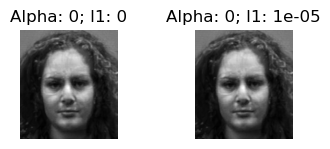

In [7]:
prob4()

(36000, 75)
(75, 153)
[17 51 25 41 20 15  5 28 24 42]
[58 19 45 16 20 10 53 21 15 29]


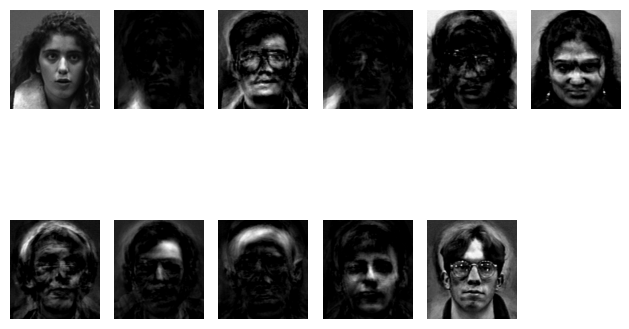

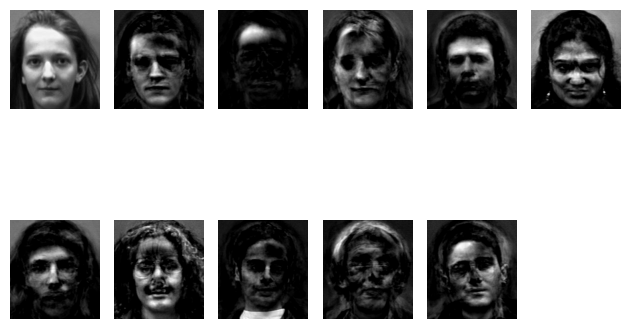

In [ ]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    # Get the faces
    faces = get_faces()

    # Run NMF using best values from previous problem
    model = NMF(n_components=75, alpha=0.2, l1_ratio=1e-5, init='random', random_state=0)
    W = model.fit_transform(faces)
    H = model.components_

    # Find 10 basis faces with largest coefficients
    sort_image_2 = np.argsort(H[:,1])[::-1][:10]
    sort_image_12 = np.argsort(H[:,11])[::-1][:10]

    print(W.shape)
    print(H.shape)
    print(sort_image_2)
    print(sort_image_12)
    
    # plot original and basis images of face 2
    plt.subplot(2,6,1)
    plt.axis('off')
    show(faces[:, 1])
    for i, index in enumerate(list(sort_image_2)):
        plt.subplot(2,6,i+2)
        plt.axis('off')
        show(W[:,index])
    plt.tight_layout()
    plt.show()

    # plot original and basis images of face 12
    plt.subplot(2,6,1)
    plt.axis('off')
    show(faces[:, 11])
    for i, index in enumerate(list(sort_image_12)):
        plt.subplot(2,6,i+2)
        plt.axis('off')
        show(W[:,index])
    plt.tight_layout()
    plt.show()

prob5()

Each of the faces covers a lot of differences that help to compose the original face.  It also looks like there may be shared basis faces between the two sets, which would show that they might factor in to more of the basis faces for other original faces than other basis faces might.  